In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [3]:
vb = pd.read_csv("../data/vb_data_3_numZone.csv")
vb_c = pd.read_csv("../data/vb_data_3_categZone.csv")
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
# clipping
q_values[q_values>1] = 1
q_values[q_values<-1] = -1
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
q_tree = y_prob_tree[:,1]*2 - 1

In [4]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
X_c = vb_c.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
#zone_cols = [col for col in list(X.columns) if 'Start' in col or 'End' in col or 'Zone' in col]
#outcome_cols = [col for col in list(X.columns) if 'Outcome' in col]

#experiment without zones
#X = X.drop(outcome_cols, axis=1)

print(len(X.columns), 'columns in numerical dataframe')
print(len(X_c.columns), 'columns in categorical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns = cols)
y = vb.RewardValue
y_q = q_values

cols = [col for col in list(X_c.columns) if X_c[col].dtype == 'object']
X_c = pd.get_dummies(data=X_c, columns = cols)

print(len(X.columns), 'columns in numerical dataframe after dummies')
print(len(X_c.columns), 'columns in categorical dataframe after dummies')

93 columns in numerical dataframe
73 columns in categorical dataframe
204 columns in numerical dataframe after dummies
926 columns in categorical dataframe after dummies


In [20]:
# Create Decision Tree regressor object
print('Training Mimic Regressor')
clf = DecisionTreeRegressor(max_depth=16, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf = clf.fit(X,y_q)
y_mimic = clf.predict(X)

# Create Decision Tree regressor object
print('Training Original Regressor')
clf_orig = DecisionTreeRegressor(max_depth=10, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf_orig = clf_orig.fit(X,y)
y_regr = clf_orig.predict(X)

from sklearn import metrics
true_prob = np.zeros([len(vb),2])
true_prob[:,0] = .5-.5*vb.RewardValue
true_prob[:,1] = 1 - true_prob[:,0]
nn_prob = np.zeros([len(vb),2])
nn_prob[:,0] = .5-.5*q_values
nn_prob[:,1] = 1 - nn_prob[:,0]
mimic_prob = np.zeros([len(vb),2])
mimic_prob[:,0] = .5-.5*y_mimic
mimic_prob[:,1] = 1 - mimic_prob[:,0]
regr_prob = np.zeros([len(vb),2])
regr_prob[:,0] = .5-.5*y_regr
regr_prob[:,1] = 1 - regr_prob[:,0]

print('Cross entropy loss for NN: %.3f' % (metrics.log_loss(true_prob,nn_prob,eps=1e-4)))
print('Cross entropy loss for Classifier Tree: %.3f' % (metrics.log_loss(true_prob,y_prob_tree,eps=1e-4)))
print('Cross entropy loss for Mimic Tree: %.3f' % (metrics.log_loss(true_prob,mimic_prob,eps=1e-4)))
print('Cross entropy loss for Regressor Tree: %.3f' % (metrics.log_loss(true_prob,regr_prob,eps=1e-4)))
print('\n')
print('Mean squared error for NN: %.3f' % (metrics.mean_squared_error(true_prob,nn_prob)))
print('Mean squared error for Classifier Tree: %.3f' % (metrics.mean_squared_error(true_prob,y_prob_tree)))
print('Mean squared error for Mimic Tree: %.3f' % (metrics.mean_squared_error(true_prob,mimic_prob)))
print('Mean squared error for Regressor Tree: %.3f' % (metrics.mean_squared_error(true_prob,regr_prob)))
print('\n')
print('ROC-AUC score for NN: %.3f' % (metrics.roc_auc_score(true_prob,nn_prob)))
print('ROC-AUC score for Classifier Tree: %.3f' % (metrics.roc_auc_score(true_prob,y_prob_tree)))
print('ROC-AUC score for Mimic Tree: %.3f' % (metrics.roc_auc_score(true_prob,mimic_prob)))
print('ROC-AUC score for Regressor Tree: %.3f' % (metrics.roc_auc_score(true_prob,regr_prob)))

Training Mimic Regressor
Training Original Regressor
Cross entropy loss for NN: 0.430
Cross entropy loss for Classifier Tree: 0.435
Cross entropy loss for Mimic Tree: 0.432
Cross entropy loss for Regressor Tree: 0.435


Mean squared error for NN: 0.151
Mean squared error for Classifier Tree: 0.153
Mean squared error for Mimic Tree: 0.152
Mean squared error for Regressor Tree: 0.153


ROC-AUC score for NN: 0.853
ROC-AUC score for Classifier Tree: 0.849
ROC-AUC score for Mimic Tree: 0.851
ROC-AUC score for Regressor Tree: 0.849


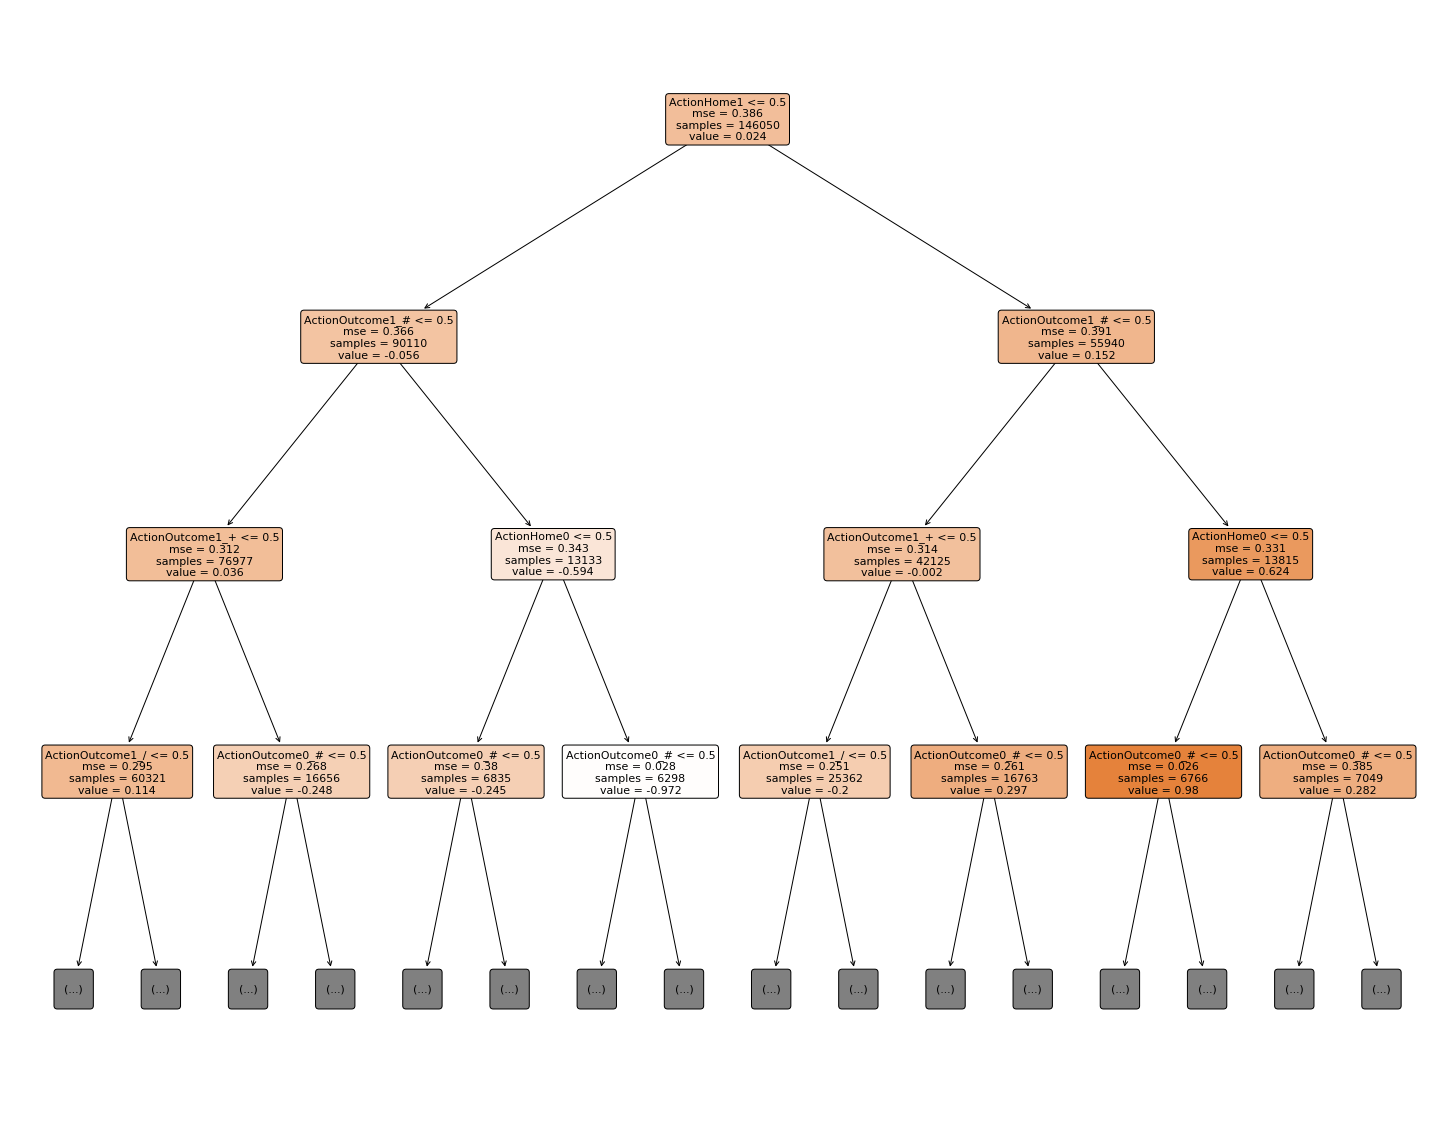

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(25,20))
plot_tree(clf, feature_names=X.columns, filled=True, rounded=True, fontsize=11, max_depth=3)
plt.show()

In [22]:
class_nn = np.sign(q_values)
class_nn[class_nn==0] = 1

class_tree = np.sign(q_tree)
class_tree[class_tree==0] = 1

class_regr = np.sign(y_regr)
class_regr[class_regr==0] = 1

class_mimic = np.sign(y_mimic)
class_mimic[class_mimic==0] = 1

print('Accuracy for NN: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_nn)))
print('Accuracy for Classifier Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_tree)))
print('Accuracy for Regressor Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_regr)))
print('Accuracy for Mimic Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_mimic)))

#print('Mean squared error for Mimic Tree: %.3f' % (metrics.accuracy_score(true_prob,mimic_prob)))
#print('Mean squared error for Regressor Tree: %.3f' % (metrics.accuracy_score(true_prob,regr_prob)))

Accuracy for NN: 0.753
Accuracy for Classifier Tree: 0.749
Accuracy for Regressor Tree: 0.749
Accuracy for Mimic Tree: 0.751


In [23]:
# Create Decision Tree regressor object
clf = DecisionTreeRegressor(max_depth=16, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf = clf.fit(X,y_q)
y_mimic = clf.predict(X)
mimic_prob = np.zeros([len(vb),2])
mimic_prob[:,0] = .5-.5*y_mimic
mimic_prob[:,1] = 1 - mimic_prob[:,0]
print('Cross entropy loss for Mimic Tree: %.3f' % (metrics.log_loss(true_prob,mimic_prob,eps=1e-6)))

Cross entropy loss for Mimic Tree: 0.432


In [6]:
for i in range(10,50,2):
    print('Checking max_depth =', i)
    clf = DecisionTreeRegressor(max_depth=i)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=y_q, cv=5, n_jobs=4)
    print('Mean cross validation accuracy:', scores.mean())

Checking max_depth = 10
Mean cross validation accuracy: 0.9661686401615377
Checking max_depth = 12
Mean cross validation accuracy: 0.9932503322000601
Checking max_depth = 14
Mean cross validation accuracy: 0.9960761278329008
Checking max_depth = 16
Mean cross validation accuracy: 0.9965362053928641
Checking max_depth = 18
Mean cross validation accuracy: 0.9966032323103647
Checking max_depth = 20
Mean cross validation accuracy: 0.9966042946353463
Checking max_depth = 22
Mean cross validation accuracy: 0.9966124457493242
Checking max_depth = 24
Mean cross validation accuracy: 0.996589838480252
Checking max_depth = 26
Mean cross validation accuracy: 0.9966194697329696
Checking max_depth = 28
Mean cross validation accuracy: 0.9966676776526606
Checking max_depth = 30
Mean cross validation accuracy: 0.9965750518191756
Checking max_depth = 32
Mean cross validation accuracy: 0.9965662848676953
Checking max_depth = 34
Mean cross validation accuracy: 0.9965846904421705
Checking max_depth = 36
Me

In [17]:
for i in range(6,20,2):
    print('Checking max_depth =', i)
    clf = DecisionTreeRegressor(max_depth=i)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=y_q, cv=5, n_jobs=4, scoring='r2')
    print('Mean cross validation accuracy:', scores.mean())

Checking max_depth = 6
Mean cross validation accuracy: 0.6172594036291839
Checking max_depth = 8
Mean cross validation accuracy: 0.8965046969251343
Checking max_depth = 10
Mean cross validation accuracy: 0.9662286072331533
Checking max_depth = 12
Mean cross validation accuracy: 0.993223924726928
Checking max_depth = 14
Mean cross validation accuracy: 0.9961022850368257
Checking max_depth = 16
Mean cross validation accuracy: 0.9965245779383245
Checking max_depth = 18
Mean cross validation accuracy: 0.9965689935721983


In [32]:
# all possibilities for scoring
print(', '.join(list(metrics.SCORERS.keys())))

explained_variance, r2, max_error, neg_median_absolute_error, neg_mean_absolute_error, neg_mean_squared_error, neg_mean_squared_log_error, neg_root_mean_squared_error, neg_mean_poisson_deviance, neg_mean_gamma_deviance, accuracy, roc_auc, roc_auc_ovr, roc_auc_ovo, roc_auc_ovr_weighted, roc_auc_ovo_weighted, balanced_accuracy, average_precision, neg_log_loss, neg_brier_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score, fowlkes_mallows_score, precision, precision_macro, precision_micro, precision_samples, precision_weighted, recall, recall_macro, recall_micro, recall_samples, recall_weighted, f1, f1_macro, f1_micro, f1_samples, f1_weighted, jaccard, jaccard_macro, jaccard_micro, jaccard_samples, jaccard_weighted


In [33]:
import pickle
clf = DecisionTreeRegressor(max_depth=16, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf = clf.fit(X,y_q)
y_mimic = clf.predict(X)
pickle.dump(y_mimic, open('../output/q_values_mimictree.pkl', 'wb'))